In [1]:
#Data Science Tools
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score,precision_recall_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as ss

#Pytorch
import torch
from torch.utils import data
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

#additional tools
import os
import copy
from tqdm.notebook import tqdm
from IPython.display import clear_output

import xgboost as xgb
import random



pd.options.mode.chained_assignment = None  # default='warn'



The code below download the datasets used for this notebook. You can use Colab or install the `gdown` Python package. You can also go to https://drive.google.com/drive/folders/1AGN2iagHvyzVxN2mPFj9Id12p7N-PKxW?usp=sharing and download the files in the folder `Session 2`

In [2]:
!gdown https://drive.google.com/uc?id=1b7V0G_94nh-mi1D54XTjeYrk47xNp0iC -O auths.csv
!gdown https://drive.google.com/uc?id=1eFAU0xBvNi9aspi4PtZY1TsiPgesmtIh -O redteam.txt.gz

Downloading...
From: https://drive.google.com/uc?id=1b7V0G_94nh-mi1D54XTjeYrk47xNp0iC
To: /content/auths.csv
77.2MB [00:00, 186MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eFAU0xBvNi9aspi4PtZY1TsiPgesmtIh
To: /content/redteam.txt.gz
100% 4.85k/4.85k [00:00<00:00, 9.47MB/s]


In [3]:
os.listdir()

['.config', 'auths.csv', '.ipynb_checkpoints', 'redteam.txt.gz', 'sample_data']

In [4]:
def get_days(t):
    day=np.floor(t/(60*60*24))
    return day

def get_hours(t):
    hrs = np.floor((t % (60*60*24))/(60*60))
    return hrs

# Import Data

Let's import our data. We have logon data with auths. We also have redteam data which will serve as the anomalies.



Let's also take a subset of the data. There's just too much to handle!

In [5]:
features=['second','source_user_domain','destination_user_domain','source_computer','destination_computer','authentication_type','logon_type','authentication_orientation','success_failure']
auths=pd.read_csv("auths.csv",compression="gzip",names=features)
auths['day']=auths.second.apply(lambda x: get_days(x))



#import and merge red team with auths
readteam_cols=['second','user_domain','source_computer','destination_computer']
redteam=pd.read_csv('redteam.txt.gz', compression='gzip',names=readteam_cols)
redteam=redteam[['second','source_computer','destination_computer']]
redteam['red']=1
auths=redteam.merge(auths,left_on=['second','source_computer','destination_computer'],right_on=['second','source_computer','destination_computer'],how='right')
auths.red[auths.red.isnull()]=0


In [6]:
# get all devices
computers=list(auths.source_computer.unique()) + list(auths.destination_computer.unique())

In [7]:
computers[1:5]

['C1710', 'C828', 'C395', 'C754']

If the Original Dataset is very large, try sample a small portion of the dataset by sampling a set of computers we consider. But this may result no positive examples since they are very rare. So we do not perform sampling here.

In [8]:
#sample the devices
# sample_size=16
# auths=auths[(auths.source_computer.isin(computers[:sample_size]))&(auths.destination_computer.isin(computers[:sample_size]))]

In order to ensure this model generalizes well, let's convert time to a more general concept: e.g day of the week and hour of the day. This has the added bonus of letting us drop a lot of duplicate data from the training set.

In [9]:
auths['hour']=auths.second.apply(lambda x: get_hours(x))
auths['dotw']=auths['day'] % 7


# no need to keep "second" value and best not to train on it.

auths.drop('second',axis=1,inplace=True)
auths.drop_duplicates(inplace=True)
features.remove('second')


In [10]:
auths.head()

,source_computer,destination_computer,red,source_user_domain,destination_user_domain,authentication_type,logon_type,authentication_orientation,success_failure,day,hour,dotw
0,C92,C92,0.0,U6@DOM1,U7@DOM1,Kerberos,Network,LogOn,Success,0.0,0.0,0.0
1,C92,C92,0.0,U7@DOM1,U6@DOM1,?,?,AuthMap,Success,0.0,0.0,0.0
2,C92,C92,0.0,U7@DOM1,U7@DOM1,?,Network,LogOff,Success,0.0,0.0,0.0
3,C92,C92,0.0,U34@DOM1,U34@DOM1,?,Network,LogOff,Success,0.0,0.0,0.0
4,C92,C92,0.0,U34@DOM1,U6@DOM1,?,?,AuthMap,Success,0.0,0.0,0.0


In [11]:
# check number of anomalies - not many!
print(auths[auths.red==1].shape[0])
#compared to actual samples
print(len(auths))

131
474858


 Convert to numerical encoding

In [12]:
value_to_category={}
for c in features:
    auths[c][auths[c]=='?']=np.NaN
    print(c)
    feat=auths[c].astype('category')
    d=dict(enumerate(feat.cat.categories))
    auths[c]=feat.cat.codes
    value_to_category[c]=d


source_user_domain
destination_user_domain
source_computer
destination_computer
authentication_type
logon_type
authentication_orientation
success_failure


In [13]:
# for converting back
category_to_value={}
for c in value_to_category.keys():
    dict_= value_to_category[c]
    category_to_value[c]={v: k for k, v in dict_.items()}

In [14]:
# include time features in features list 
features=features+['day','hour','dotw']


Let's split the data into train and test. The red team event occurs in the middle of the timeline. Not great for us, but we can cheat a little because we've removed the concept of time beyond a day, so turning the red team event into our test set is ok

In [15]:
train_real=auths[features][(auths.day<8) | (auths.day>14)].copy()

test=auths[(auths.day>=8) & (auths.day<=14)]


# Make negative samples

Now we're going to generate the fake data. We need to know the distribution of each variable for this. It's also important that the negative samples are generated from the training data. 

In [16]:
#you can select which features you want to perturb

variable_features=[
 'source_user_domain',
 'destination_user_domain',
 'source_computer',
 'destination_computer',
 'authentication_type',
 'logon_type',
 'authentication_orientation',
 'success_failure',
 'hour',
 'dotw']

In [17]:

distributions={}
for c in variable_features:
    distributions[c]=train_real[c].value_counts()


In [18]:
num=int(15*len(train_real)/(len(variable_features)))


fake_list=[]
sampling='most probable'
for feat in tqdm(variable_features):#[::-1]:
    dist=(distributions[feat])
    dist=dist/dist.sum()
    if sampling=='uniform':
        p=1/len(dist)*np.ones(len(dist))
    elif sampling=='most probable':
        p=dist.values
    values=np.random.choice(dist.index, num,p=p)
    random_sample=train_real.sample(num,replace=True)
    random_sample[feat]=values
    fake_list.append(random_sample)

In [19]:
train_real['already_exists']=1

In [20]:
fake = pd.concat(fake_list)
fake=fake[features].merge(train_real[features+['already_exists']],left_on=features,right_on=features, how='left'  )
del fake_list
fake=fake[(fake.already_exists.isnull())]

In [21]:
train_real['label']=0
fake['label']=1


In [22]:
train=pd.concat([train_real,fake])

In [23]:
train[train.label==0].shape[0]/train[train.label==1].shape[0]

0.11508595729331086

In [24]:
train.sort_values('day',inplace=True)

In [25]:
train.head()

,source_user_domain,destination_user_domain,source_computer,destination_computer,authentication_type,logon_type,authentication_orientation,success_failure,day,hour,dotw,already_exists,label
0,13233,13672,19,17,0,3,2,1,0.0,0.0,0.0,1.0,0
264765,7327,13896,2,2,3,2,2,1,0.0,7.0,0.0,NaN,1
264741,13554,4447,3,3,-1,3,1,1,0.0,14.0,0.0,NaN,1
264736,12250,12750,0,0,-1,3,1,1,0.0,8.0,0.0,NaN,1
4003719,12579,13492,2,2,3,2,6,1,0.0,7.0,0.0,NaN,1


# Train model

In [26]:
split=int(len(train)*.8)
X_train = train.iloc[:split].sample(frac=1)
X_val = train.iloc[split:].sample(frac=1)

y_train = X_train['label'].values

y_val = X_val['label'].values

X_train = X_train[features].values
X_val = X_val[features].values

In [27]:
## experiment with different validation sets. You may find that a split with respect to time is more informative than a random split
# X_train, X_val, y_train, y_val = train_test_split(train[features].values,train['label'].values, test_size=0.2, random_state=123,shuffle=True)


In [28]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_val = xgb.DMatrix(X_val, label=y_val)


In [29]:
param = {'booster' : 'dart',
    'eta': 1, # training rate. Set to the max!
    'rate_drop' : .1,
    'max_depth': 3,  # larger values may cause over fitting
    'lambda' : 4,
    'objective': 'binary:logistic',  
    'eval_metric': ['logloss','aucpr','map'], #various metrics to keep you informed
    'scale_pos_weight' : .10, # class weighting that we learned last week. for the positive class so here it is small.
    'tree_method ' : 'gpu_hist', # trains faster on gpu
    'verbosity' : 1}  # to get updates from xgboost
evallist = [(D_val, 'val'), (D_train, 'train')] # what to monitor

num_round = 25  # The number of training iterations

In [30]:
# Use GPU instead of CPU
use_cuda = True

In [31]:
model = xgb.train(param, D_train, num_round,evallist)
# 

[0]	val-logloss:0.869941	val-aucpr:0.93273	val-map:0.932669	train-logloss:0.717916	train-aucpr:0.940945	train-map:0.941013
[1]	val-logloss:0.838539	val-aucpr:0.944708	val-map:0.944668	train-logloss:0.717916	train-aucpr:0.940945	train-map:0.941013
[2]	val-logloss:0.807538	val-aucpr:0.951643	val-map:0.95154	train-logloss:0.693147	train-aucpr:0.895503	train-map:0.895668
[3]	val-logloss:0.793537	val-aucpr:0.952006	val-map:0.952038	train-logloss:0.664367	train-aucpr:0.954373	train-map:0.954385
[4]	val-logloss:0.805393	val-aucpr:0.95117	val-map:0.95111	train-logloss:0.662085	train-aucpr:0.954707	train-map:0.954708
[5]	val-logloss:0.803025	val-aucpr:0.947103	val-map:0.947152	train-logloss:0.662564	train-aucpr:0.954781	train-map:0.954784
[6]	val-logloss:0.432149	val-aucpr:0.939312	val-map:0.9393	train-logloss:0.662166	train-aucpr:0.954382	train-map:0.954354
[7]	val-logloss:0.403618	val-aucpr:0.941145	val-map:0.941102	train-logloss:0.652654	train-aucpr:0.955676	train-map:0.95567
[8]	val-logloss

In [32]:
preds=(model.predict(D_val)>.1).astype(int)
print("Precision = {}".format(precision_score(y_val, preds, average='macro')))
print("Recall = {}".format(recall_score(y_val, preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_val, preds)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision = 0.4509742212524303
Recall = 0.5
Accuracy = 0.9019484425048606


(array([     0.,      0.,      0.,      0.,      0., 786423.,      0.,
             0.,      0.,      0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

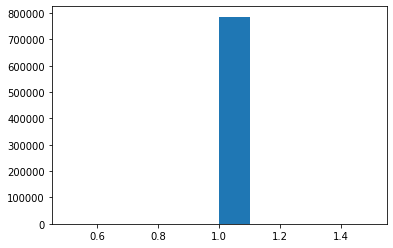

In [33]:
plt.hist(preds)

# Finding Anomalies

As usual, we normally don't have labels, but let's assess our performance using the red team events as labels

In [34]:
xg_test=xgb.DMatrix(test[features].values)
pred_test=model.predict(xg_test)
test['prediction']=pred_test
pred_test=(pred_test>.9).astype(int)
y_test=test.red.to_numpy()
print("Precision = {}".format(precision_score(y_test, pred_test, average='macro')))
print("Recall = {}".format(recall_score(y_test, pred_test, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, pred_test)))


Precision = 0.49913804343102175
Recall = 0.49997823342475295
Accuracy = 0.9982327036736586


In [35]:
#let's sprt our predictions and get the top N
test.sort_values("prediction",inplace=True,ascending=False)
N=100
top_n=test.head(N)

In [36]:
test.red.value_counts()

0.0    68913
1.0      119
Name: red, dtype: int64

In [37]:
# How many did we get right?
top_n[top_n.red==1].shape

(8, 13)

Plot the distribution of the test set predictions, as well as the red team event. The test set distribution (not the red team distribution) should be used to inform you of the quality of the anomaly detector.

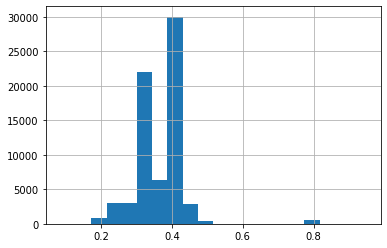

In [38]:
test['prediction'].hist(bins=20)

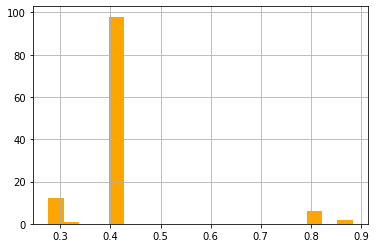

In [39]:
test['prediction'][test.red==1].hist(bins=20,color='orange')